In [2]:
# import necessary packages
import torch
import torchvision
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from copy import deepcopy
from torch.utils.data import Subset
import torch.nn as nn
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [215]:
# Cifar100 data import
# Normalization to apply to the validation and the testing set
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))  # Normalize the images
])
# Data Augmentation to apply to the training set
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])
# Download and load the training data
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# FER2013 data import 
# Download and load the FER2013, split it to train and test
# Need to download it from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge
fer2013train = datasets.FER2013(root='./data', transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [170]:
# Split the CIFAR100 dataset into training, validation, testing set of the fine and coarse labels
# Transform 
def sparse2coarse(targets):
    """Convert Pytorch CIFAR100 sparse targets to coarse targets.

    Usage:
        trainset = torchvision.datasets.CIFAR100(path)
        trainset.targets = sparse2coarse(trainset.targets)
    """
    coarse_labels = np.array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,  
                               3, 14,  9, 18,  7, 11,  3,  9,  7, 11,
                               6, 11,  5, 10,  7,  6, 13, 15,  3, 15,  
                               0, 11,  1, 10, 12, 14, 16,  9, 11,  5, 
                               5, 19,  8,  8, 15, 13, 14, 17, 18, 10, 
                               16, 4, 17,  4,  2,  0, 17,  4, 18, 17, 
                               10, 3,  2, 12, 12, 16, 12,  1,  9, 19,  
                               2, 10,  0,  1, 16, 12,  9, 13, 15, 13, 
                              16, 19,  2,  4,  6, 19,  5,  5,  8, 19, 
                              18,  1,  2, 15,  6,  0, 17,  8, 14, 13])
    return coarse_labels[targets]
# Data Structure to store the transformed dataset
class TransformedSubset(Subset):
    def __init__(self, dataset, indices, transform):
        super(TransformedSubset, self).__init__(dataset, indices)
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        img = self.transform(img)
        return img, label
# Construct Coarse Dataset With the Function
superclasses = ['aquatic_mammals','fish','flowers','food_containers','fruit_and_vegetables','household_electrical_devices',
                'household_furniture','insects','large_carnivores','large_man-made_outdoor_things','large_natural_outdoor_scenes',
                'large_omnivores_and_herbivores','medium-sized_mammals','non-insect_invertebrates','people','reptiles','small_mammals',
                'trees','vehicles 1','vehicles 2']
# Convert the CIFAR100 dataset to the coarse version
trainset_coarse = deepcopy(trainset)
trainset_coarse.targets = sparse2coarse(trainset_coarse.targets)
trainset_coarse.classes = superclasses
trainset_coarse.class_to_idx = dict(zip(trainset_coarse.classes,range(len(trainset_coarse.classes))))
testset_coarse = deepcopy(testset)
testset_coarse.targets = sparse2coarse(testset_coarse.targets)
testset_coarse.classes = superclasses
testset_coarse.class_to_idx = dict(zip(testset_coarse.classes, range(len(testset_coarse.classes))))
# Split the training dataset into training and validation set
trainsplit_coarse_idx, validsplit_coarse_idx = random_split(trainset_coarse,[int(len(trainset_coarse) * 0.9), len(trainset_coarse) - int(len(trainset_coarse) * 0.9)])
trainsplit_fine_idx, validsplit_fine_idx = random_split(trainset,[int(len(trainset) * 0.9), len(trainset) - int(len(trainset) * 0.9)])
# Make Subset and apply the transforms
trainsplit_coarse = TransformedSubset(trainset_coarse, trainsplit_coarse_idx.indices, augmentation_transform)
validsplit_coarse = TransformedSubset(trainset_coarse, validsplit_coarse_idx.indices, transform)
trainsplit_fine = TransformedSubset(trainset, trainsplit_fine_idx.indices, augmentation_transform)
validsplit_fine = TransformedSubset(trainset, validsplit_fine_idx.indices, transform)


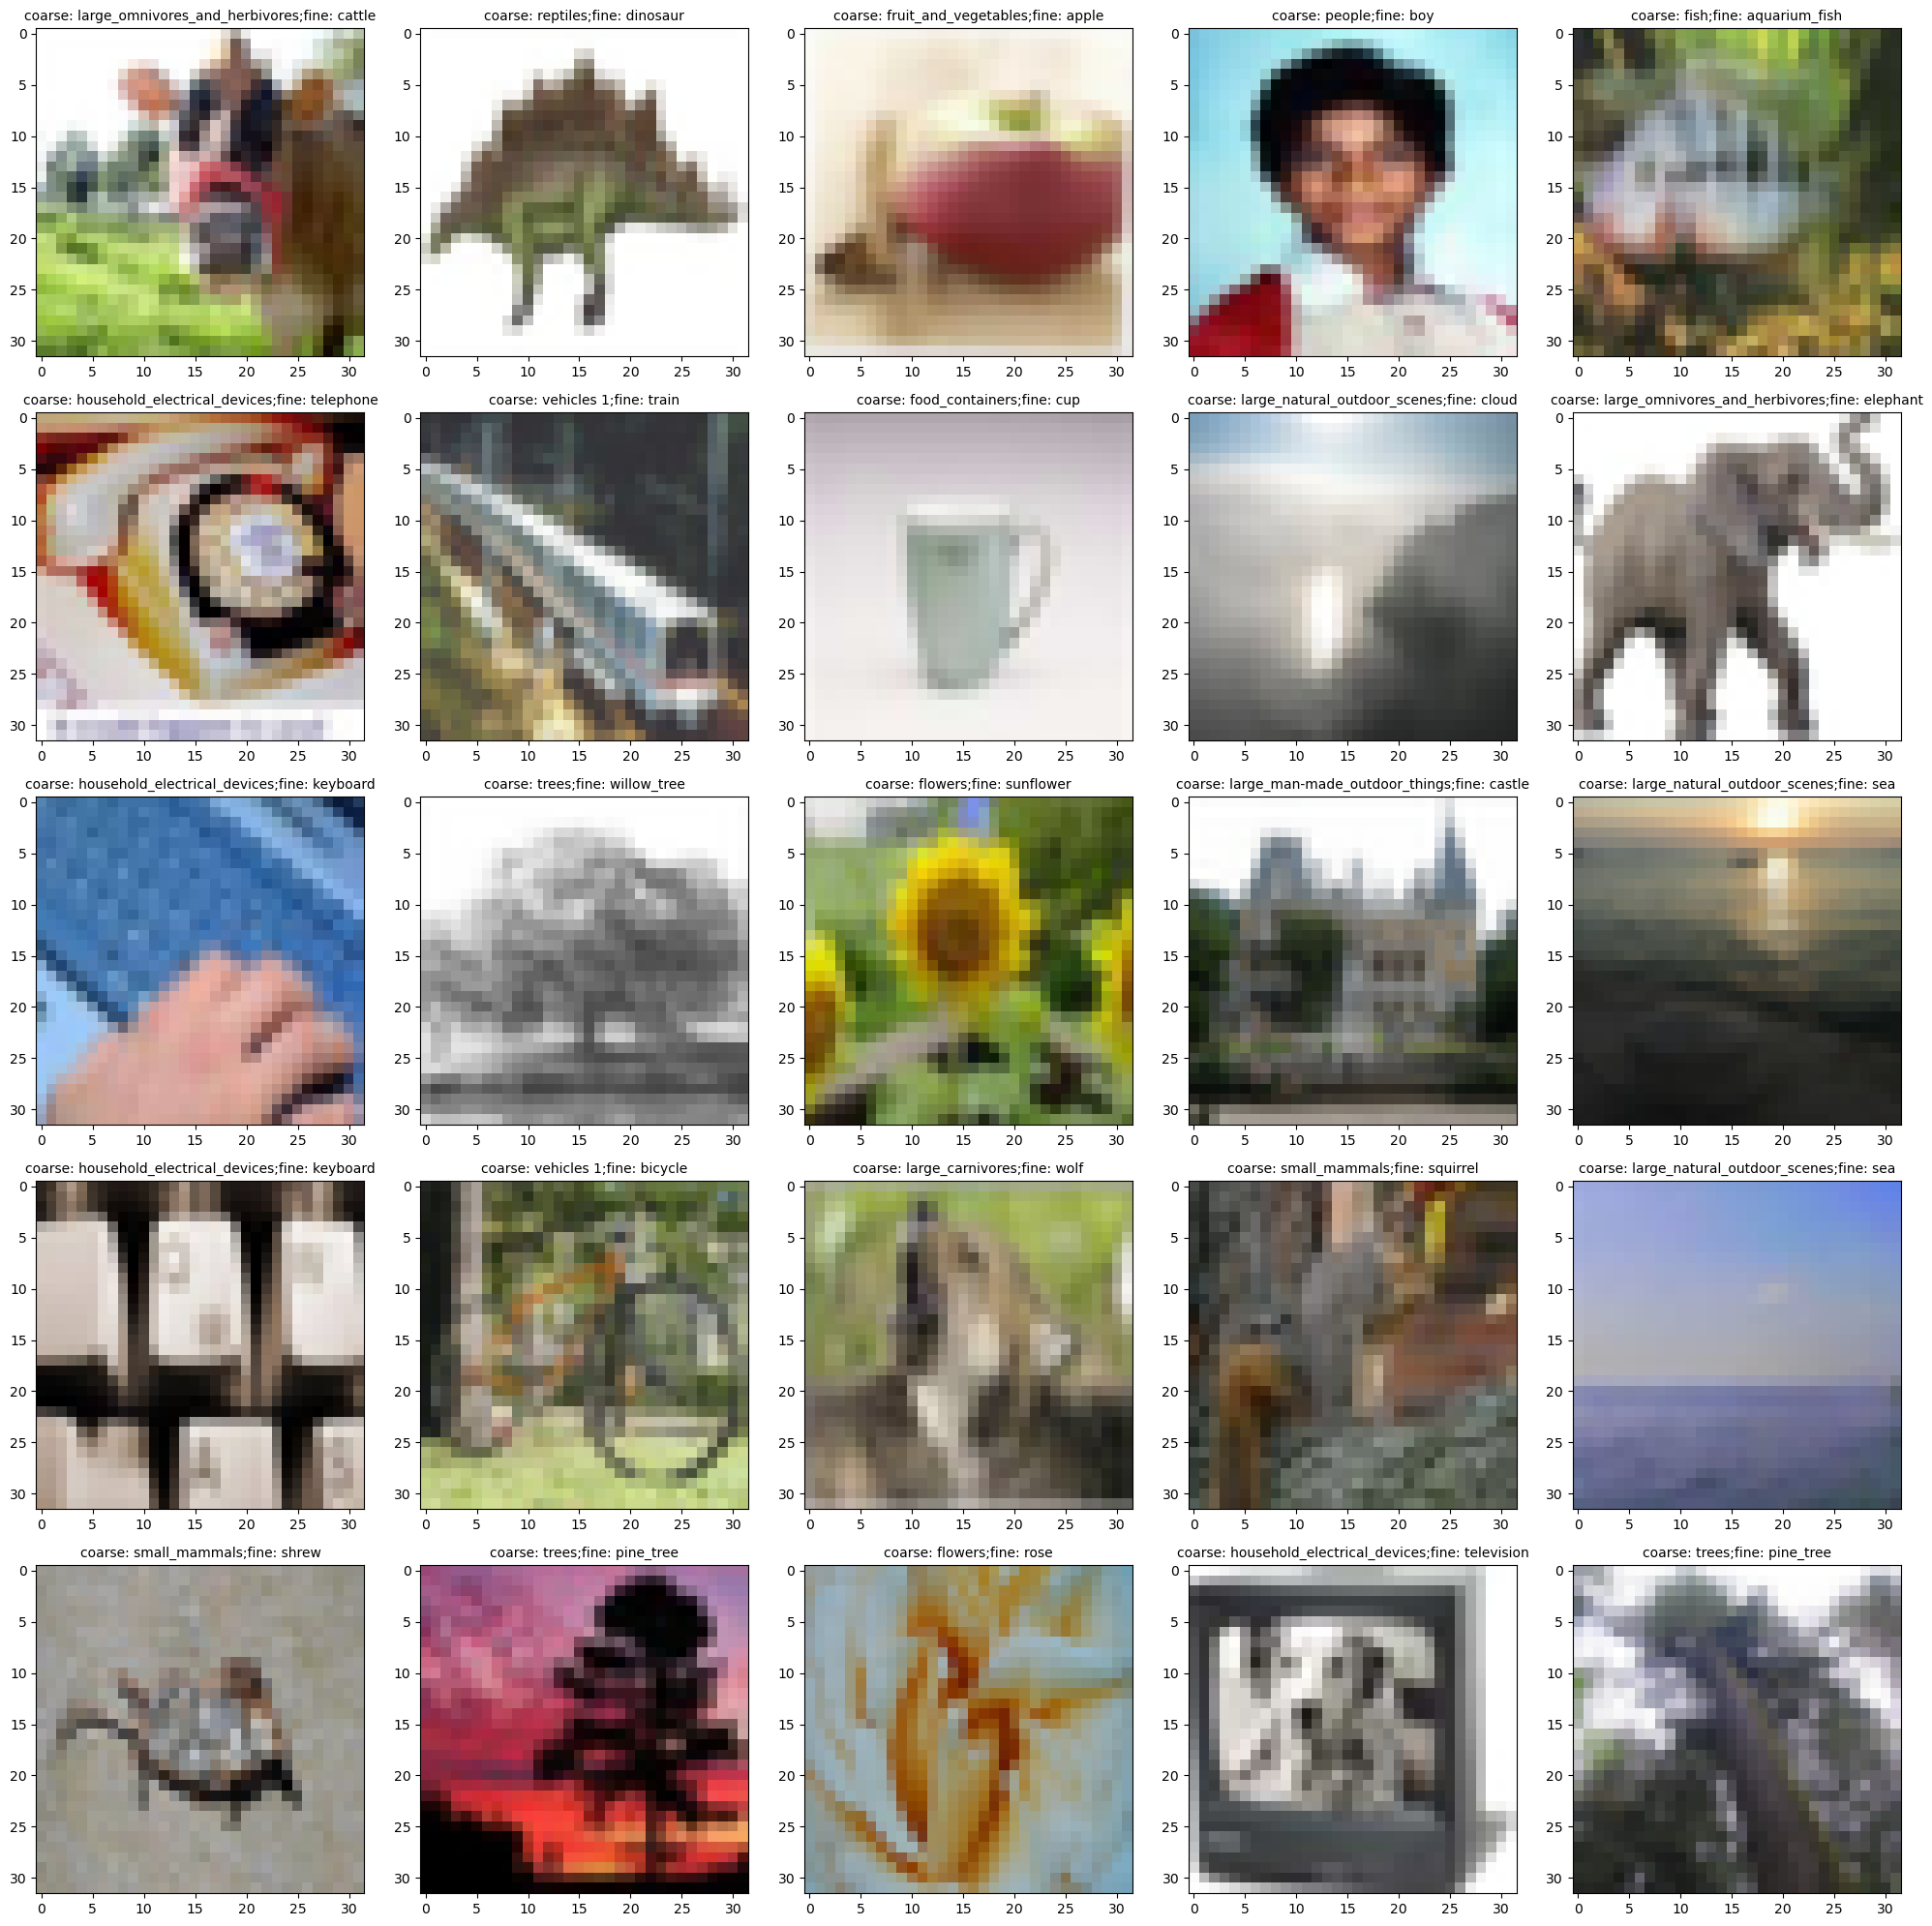

In [223]:
# Visualize Coarse Dataset
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,5, figsize = (20,20))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(np.array(trainset[i*5 + j][0]))
        ax[i,j].set_title(f'coarse: {trainset_coarse.classes[trainset_coarse[i*5 + j][1]]};fine: {trainset.classes[trainset[i*5 + j][1]]}',fontsize = 10)
plt.tight_layout()
plt.show()

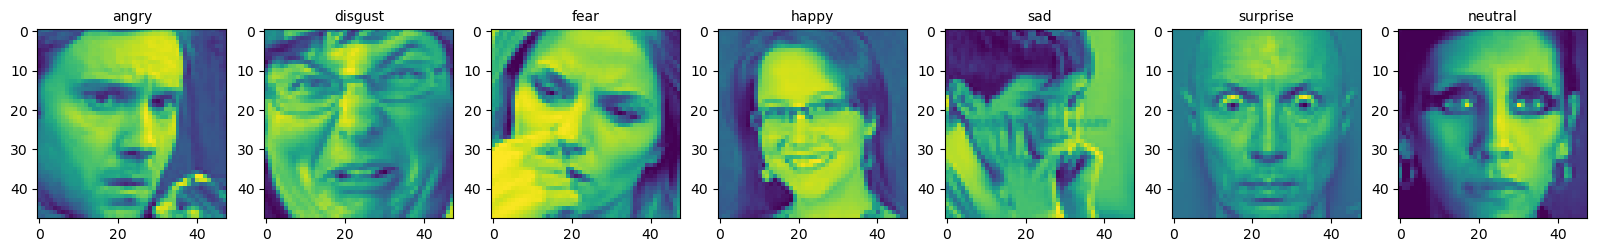

In [221]:
# select one image from FER2013 dataset for each target type
# FER2013 dataset contains 7 classes
fer2013_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
fig, ax = plt.subplots(1,7, figsize = (20,5))
for i in range(7):
    for j in range(len(fer2013train)):
        if fer2013train[j][1] == i:
            ax[i].imshow(np.array(fer2013train[j][0]))
            ax[i].set_title(f'{fer2013_classes[i]}',fontsize = 10)
            break

In [171]:


# Define the Predict Function
def predict(output):
    return torch.argmax(output, dim = 1)

# Define the Train Function
def train(model, train_dataloader, valid_dataloader, epochs, save_path, save_name, checkpoint_path=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Training on device: {device}')
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min = 0)
    criterion = torch.nn.CrossEntropyLoss()
    best_loss = float('inf')
    start_epoch = 0
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_loss = checkpoint.get('best_loss', best_loss)
        print(f"Resumed training from epoch {start_epoch} with best validation loss {best_loss}")

    trloss_arr = []
    tracc_arr = []
    vldloss_arr = []
    vldacc_arr = []
    for epoch in range(start_epoch,epochs):
        model.train()
        train_loss = 0
        corrects = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), torch.tensor(labels, dtype = torch.long).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            corrects += torch.sum(torch.eq(predict(outputs), labels))
            total += inputs.size(0)
        trloss_arr.append(train_loss / len(train_dataloader))
        tracc_arr.append(corrects / total)

        model.eval()
        valid_loss = 0
        corrects = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs, labels = inputs.to(device), labels.to(device).long()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                corrects += torch.sum(torch.eq(predict(outputs),labels))
                total += inputs.size(0)
            vldloss_arr.append(valid_loss / len(valid_dataloader))
            vldacc_arr.append(corrects / total)
        print('Epoch: {ep}, TrainingLoss: {tl}, TrainingAccuracy: {ta}, ValidationLoss: {vl}, ValidationAccuracy: {va}'.format(ep = epoch, tl = trloss_arr[-1], ta = tracc_arr[-1], vl = vldloss_arr[-1], va = vldacc_arr[-1]))
        
        if vldloss_arr[-1] < best_loss:
            best_loss = vldloss_arr[-1]
            torch.save({'epoch': epoch + 1,
             'model_state_dict': model.state_dict(), 
             'optimizer_state_dict':optimizer.state_dict(), 
             'scheduler_state_dict':scheduler.state_dict(),
             'best_loss': best_loss},
                       f'{save_path}/{save_name}.pth')
            print('Best Loss: saving model...')

    return trloss_arr, tracc_arr, vldloss_arr, vldacc_arr

# Define the Test Function
def test(model, test_dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    model.eval()
    
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = 0
    corrects = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            corrects += torch.sum(torch.eq(predict(outputs),labels))
            total += inputs.size(0)
        avg_test_loss = test_loss / len(test_dataloader)
        test_accuracy = float((corrects / total).cpu())
    
    print(f'Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}')
    return avg_test_loss, test_accuracy

In [ ]:
# Prepare the Dataloaders for the training, validation and testing set
coarsetrain_loader = DataLoader(trainsplit_coarse, batch_size = 256, shuffle= True)
coarsevalid_loader = DataLoader(validsplit_coarse, batch_size = 256, shuffle= True)
coarsetest_loader = DataLoader(testset_coarse, batch_size = 256, shuffle= True)
finetrain_loader = DataLoader(trainsplit_fine, batch_size = 256, shuffle= True)
finevalid_loader = DataLoader(validsplit_fine, batch_size = 256, shuffle= True)
finetest_loader = DataLoader(testset, batch_size = 256, shuffle= True)

In [21]:
# Pretrain Model On CIFAR100 Coarse Labels
coarse_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
coarse_model.fc = torch.nn.Linear(coarse_model.fc.in_features, 20)
trloss_arr, tracc_arr, vldloss_arr, vldacc_arr = train(coarse_model, coarsetrain_loader, coarsevalid_loader, 200, '.', 'resnet20_coarse_real')

Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Training on device: cuda
Epoch: 0, TrainingLoss: 2.500172337347811, TrainingAccuracy: 0.22031112015247345, ValidationLoss: 2.3064477920532225, ValidationAccuracy: 0.2849999964237213
Best Loss: saving model...
Epoch: 1, TrainingLoss: 2.108361216431314, TrainingAccuracy: 0.33791112899780273, ValidationLoss: 2.2036532878875734, ValidationAccuracy: 0.3245999813079834
Best Loss: saving model...
Epoch: 2, TrainingLoss: 1.8667326840487393, TrainingAccuracy: 0.40995556116104126, ValidationLoss: 2.056222552061081, ValidationAccuracy: 0.3893999755382538
Best Loss: saving model...
Epoch: 3, TrainingLoss: 1.67891806431792, TrainingAccuracy: 0.46542221307754517, ValidationLoss: 1.76251979470253, ValidationAccuracy: 0.43719998002052307
Best Loss: saving model...
Epoch: 4, TrainingLoss: 1.5491373694755814, TrainingAccuracy: 0.5035333633422852, ValidationLoss: 1.6509767949581147, ValidationAccuracy: 0.4797999858856201
Best Loss: saving model...
Epoch: 5, TrainingLoss: 1.4521445320411162, TrainingAccur

In [58]:
# Pretrain Model On CIFAR100 Fine Labels # NOT NEEDED
torch.cuda.empty_cache()
fine_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
fine_model.fc = torch.nn.Linear(coarse_model.fc.in_features, 100)
trloss_arr, tracc_arr, vldloss_arr, vldacc_arr = train(fine_model, finetrain_loader, finevalid_loader, 200, '.', 'resnet20_fine')

Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Training on device: cuda
Epoch: 0, TrainingLoss: 2.425452920523557, TrainingAccuracy: 0.25086668133735657, ValidationLoss: 2.1979587078094482, ValidationAccuracy: 0.3093999922275543
Best Loss: saving model...
Epoch: 1, TrainingLoss: 1.9265049587596546, TrainingAccuracy: 0.3915555477142334, ValidationLoss: 1.9970342993736268, ValidationAccuracy: 0.3799999952316284
Best Loss: saving model...
Epoch: 2, TrainingLoss: 1.6550040753050284, TrainingAccuracy: 0.4712222218513489, ValidationLoss: 1.804657942056656, ValidationAccuracy: 0.4309999942779541
Best Loss: saving model...
Epoch: 3, TrainingLoss: 1.4589684781703083, TrainingAccuracy: 0.5331110954284668, ValidationLoss: 1.7275779008865357, ValidationAccuracy: 0.4529999792575836
Best Loss: saving model...
Epoch: 4, TrainingLoss: 1.3230796734040433, TrainingAccuracy: 0.5713333487510681, ValidationLoss: 1.5299953758716582, ValidationAccuracy: 0.5189999938011169
Best Loss: saving model...
Epoch: 5, TrainingLoss: 1.2181928090073846, TrainingAccu

([2.425452920523557,
  1.9265049587596546,
  1.6550040753050284,
  1.4589684781703083,
  1.3230796734040433,
  1.2181928090073846,
  1.1334539601071314,
  1.0688073174519972,
  1.0080675801092929,
  0.9564900323748589,
  0.9196664081378416,
  0.8799021982333877,
  0.8452326689254154,
  0.8079515936022456,
  0.7858997231180017,
  0.7532539746978066,
  0.7348016290502115,
  0.7122712665322152,
  0.6838194309649143,
  0.6685212623666633,
  0.6586238948458975,
  0.6361003101549365,
  0.6241168544035066,
  0.607518411156806,
  0.5993669563057747,
  0.5830655014989051,
  0.5737294217740948,
  0.5638228729367256,
  0.5506534456190738,
  0.5519423384896733,
  0.5339544259689071,
  0.5246532953936945,
  0.5100700724869967,
  0.5262558253651316,
  0.5058946931226687,
  0.5021081404252485,
  0.49111500331623986,
  0.49000582251359115,
  0.4856489920480685,
  0.4808296254751357,
  0.4860052681443366,
  0.4674715587699955,
  0.47294086624275555,
  0.4761703017760407,
  0.4446458752182397,
  0.47607

In [8]:
# Prepare the Dataloaders for the training, validation and testing set of the finetuning process
aqua_animal_train_idx = [i for i in trainsplit_coarse_idx.indices if sparse2coarse(trainset.targets[i]) == 0]
aqua_animal_valid_idx = [i for i in validsplit_coarse_idx.indices if sparse2coarse(trainset.targets[i]) == 0]
fish_train_idx = [i for i in trainsplit_coarse_idx.indices if sparse2coarse(trainset.targets[i]) == 1]
fish_valid_idx = [i for i in validsplit_coarse_idx.indices if sparse2coarse(trainset.targets[i]) == 1]
aqua_dataset = TransformedSubset(trainset, aqua_animal_train_idx, augmentation_transform)
aqua_valid_dataset =TransformedSubset(trainset, aqua_animal_valid_idx, transform)
fish_dataset = TransformedSubset(trainset, fish_train_idx, augmentation_transform)
fish_valid_dataset =TransformedSubset(trainset, fish_valid_idx, transform)
aqua_trainloader = DataLoader(aqua_dataset, batch_size = 32, shuffle = True)
fish_trainloader = DataLoader(fish_dataset, batch_size = 32, shuffle = True)
aqua_validloader = DataLoader(aqua_valid_dataset, batch_size = 32)
fish_validloader = DataLoader(fish_valid_dataset, batch_size = 32)
aqua_animal_test_idx = [i for i in range(len(testset)) if sparse2coarse(testset.targets[i]) == 0]
aqua_testset = TransformedSubset(testset, aqua_animal_test_idx, transform)
aqua_testloader = DataLoader(aqua_testset, batch_size = 32)
fish_animal_test_idx = [i for i in range(len(testset)) if sparse2coarse(testset.targets[i]) == 1]
fish_testset = TransformedSubset(testset, fish_animal_test_idx, transform)
fish_testloader = DataLoader(fish_testset, batch_size = 32)

In [33]:
# Pretrained Model on Coarse Label, modify the last layer to fit the fine label
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
base_model.fc = torch.nn.Linear(base_model.fc.in_features, 20)
checkpoint = torch.load('resnet20_coarse_real.pth', map_location=device)
base_model.load_state_dict(checkpoint['model_state_dict'])
base_model.fc = torch.nn.Linear(base_model.fc.in_features, 100)


Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [34]:
# finetune for each model
a,b,c,d = train(deepcopy(base_model), aqua_trainloader, aqua_validloader ,20,'.','aquatic_resnet20',None)
a,b,c,d = train(deepcopy(base_model), fish_trainloader, fish_validloader ,20,'.','fish_resnet20',None)

Training on device: cuda
Epoch: 0, TrainingLoss: 1.3760848624838724, TrainingAccuracy: 0.4550241231918335, ValidationLoss: 1.7972502538136073, ValidationAccuracy: 0.3710407316684723
Best Loss: saving model...
Epoch: 1, TrainingLoss: 1.1203332650992606, TrainingAccuracy: 0.5133830308914185, ValidationLoss: 1.3994393859590804, ValidationAccuracy: 0.4117647111415863
Best Loss: saving model...
Epoch: 2, TrainingLoss: 1.0757584331764116, TrainingAccuracy: 0.5392715930938721, ValidationLoss: 1.3491632086890084, ValidationAccuracy: 0.4751131534576416
Best Loss: saving model...
Epoch: 3, TrainingLoss: 1.0027580112218857, TrainingAccuracy: 0.5603334903717041, ValidationLoss: 1.2777282510484969, ValidationAccuracy: 0.5067873597145081
Best Loss: saving model...
Epoch: 4, TrainingLoss: 0.9619619126121203, TrainingAccuracy: 0.5919262766838074, ValidationLoss: 1.1998826605933053, ValidationAccuracy: 0.5067873597145081
Best Loss: saving model...
Epoch: 5, TrainingLoss: 0.9460216412941614, TrainingAcc

In [194]:
# Define the Merged Model Function
class MergedModel(nn.Module):
    def __init__(self, model1, model2, model_original):
        super(MergedModel, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model1 = model1
        self.model2 = model2
        self.model_original = model_original
        self.model_original.to(self.device)
        self.partial_merge_model1 = deepcopy(model1)
        self.partial_merge_model1.to(self.device)
        self.partial_merge_model2 = deepcopy(model2)
        self.partial_merge_model2.to(self.device)
        self.merged_layers = []

    def forward(self, x):
        x1 = self.partial_merge_model1(x)
        x2 = self.partial_merge_model2(x)
        return x1, x2
    
    # get first n conv2d layers of a given model
    def get_first_n_conv2d_layers(self, model, n):
        if n <= 0:
            return []
        layers = []
        for name, module in model.named_modules():
            if isinstance(module, nn.Conv2d):
                layers.append((name, module))
                if len(layers) == n:
                    break
        return layers
    
    # calculate the L1 distance matrix between two conv2d layers
    def calculate_l1_distance_matrix(self, layer1, layer2):
        # get the weights of the two layers
        weights1 = layer1.weight.data
        weights2 = layer2.weight.data
        
        # calculate the L1 distance matrix
        l1_distance_matrix = torch.zeros(weights1.size(0), weights2.size(0))
        for i in range(weights1.size(0)):
            for j in range(weights2.size(0)):
                l1_distance_matrix[i, j] = torch.norm(weights1[i] - weights2[j], p=1)
        
        return l1_distance_matrix
    
    # get the indices of the filters that are most similar between two conv2d layers
    def get_most_similar_filters(self, layer1, layer2):
        # calculate the L1 distance matrix
        l1_distance_matrix = self.calculate_l1_distance_matrix(layer1, layer2)
        
        # apply the Hungarian algorithm to find the optimal filter indices
        row_indices, col_indices = linear_sum_assignment(l1_distance_matrix)
        
        return row_indices, col_indices
    
    # merge the filters of two conv2d layers
    def merge_filters(self, layer1, layer2, row_indices, col_indices):
        # get the weights of the two layers
        weights1 = layer1.weight.data
        weights2 = layer2.weight.data
        
        # merge the filters
        merged_weights = (weights1[row_indices] + weights2[col_indices]) / 2
        
        return merged_weights
    
    # merge the filters of two conv2d layers by calculating the similarity between filters and calculate their difference in reference to a new layer3
    # if the difference aligns, take the average of the two filters, else take the filter from layer3
    def merge_filters_with_reference(self, layer1, layer2, layer3):
        # get the weights of the three layers
        weights1 = layer1.weight.data
        weights2 = layer2.weight.data
        weights3 = layer3.weight.data
        
        # calculate the elementwise differences between filters in layer1 and 2 and layer3
        diff1 = weights1 - weights3
        diff2 = weights2 - weights3
        # make a true false array same shape as the weight, true of signs are the same
        same_sign = torch.sign(diff1) == torch.sign(diff2)
        # average the element if sign same, take the element from layer3 if sign is different for each element
        merged_weights = torch.where(same_sign, (weights1 + weights2) / 2, weights3)        
        return merged_weights
    
    # merge the first n pairs of conv2d layers in model1 and model2, replace the first n conv2d layers in partial_merge_model1 and partial_merge_model2 with the merged filters
    def merge_layers(self, n):
        if n <= 0:
            return
        # get the first n conv2d layers of model1 and model2
        model1_layers = self.get_first_n_conv2d_layers(self.model1, n)
        model2_layers = self.get_first_n_conv2d_layers(self.model2, n)
        
        # merge the filters of the first n pairs of conv2d layers
        for i in range(n):
            layer1 = model1_layers[i][1]
            layer2 = model2_layers[i][1]
            row_indices, col_indices = self.get_most_similar_filters(layer1, layer2)
            merged_weights = self.merge_filters(layer1, layer2, row_indices, col_indices)
            self.partial_merge_model1.state_dict()[model1_layers[i][0] + '.weight'].copy_(merged_weights)
            self.partial_merge_model2.state_dict()[model2_layers[i][0] + '.weight'].copy_(merged_weights)
            self.merged_layers.append((model1_layers[i][0], model2_layers[i][0], row_indices, col_indices))


    # similar function to merge_layers but merge by using self.model_original as reference to decide which filter to take
    def merge_layers_with_reference(self, n):
        if n <= 0:
            return
        # get the first n conv2d layers of model1 and model2
        model1_layers = self.get_first_n_conv2d_layers(self.model1, n)
        model2_layers = self.get_first_n_conv2d_layers(self.model2, n)
        model_original_layers = self.get_first_n_conv2d_layers(self.model_original, n)
        
        # merge the filters of the first n pairs of conv2d layers
        for i in range(n):
            layer1 = model1_layers[i][1]
            layer2 = model2_layers[i][1]
            layer3 = model_original_layers[i][1]
            merged_weights = self.merge_filters_with_reference(layer1, layer2, layer3)
            self.partial_merge_model1.state_dict()[model1_layers[i][0] + '.weight'].copy_(merged_weights)
            self.partial_merge_model2.state_dict()[model2_layers[i][0] + '.weight'].copy_(merged_weights)
            self.merged_layers.append((model1_layers[i][0], model2_layers[i][0]))


    # similar function to merge_layers but merge by just average, not by similarity
    def merge_layers_average(self, n):
        # get the first n conv2d layers of model1 and model2
        model1_layers = self.get_first_n_conv2d_layers(self.model1, n)
        model2_layers = self.get_first_n_conv2d_layers(self.model2, n)
        
        # merge the filters of the first n pairs of conv2d layers
        for i in range(n):
            layer1 = model1_layers[i][1]
            layer2 = model2_layers[i][1]
            merged_weights = (layer1.weight.data + layer2.weight.data) / 2
            self.partial_merge_model1.state_dict()[model1_layers[i][0] + '.weight'].copy_(merged_weights)
            self.partial_merge_model2.state_dict()[model2_layers[i][0] + '.weight'].copy_(merged_weights)
            self.merged_layers.append((model1_layers[i][0], model2_layers[i][0]))

In [192]:
# reload the finetuned aquatic and fish models
aquatic_model = torch.load('aquatic_resnet20.pth', map_location='cuda')
aquatic = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
aquatic.load_state_dict(aquatic_model['model_state_dict'])
fish_model = torch.load('fish_resnet20.pth', map_location='cuda')
fish = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
fish.load_state_dict(fish_model['model_state_dict'])
# evaluate the aquatic and fish models on dataset aqua and fish
aqua_loss, aqua_acc = test(aquatic, aqua_testloader)
fish_loss, fish_acc = test(fish, fish_testloader)
# load the coarse model resnet20_corase_real as a reference model
coarse_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
coarse_model.fc = torch.nn.Linear(coarse_model.fc.in_features, 20)
checkpoint = torch.load('resnet20_coarse_real.pth', map_location='cuda')
coarse_model.load_state_dict(checkpoint['model_state_dict'])

Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master
Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Test Loss: 1.0391607619822025, Test Accuracy: 0.5820000171661377
Test Loss: 0.8241297174245119, Test Accuracy: 0.734000027179718


Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


<All keys matched successfully>

Test Loss: 1.0391607619822025, Test Accuracy: 0.5820000171661377
Test Loss: 0.8241297174245119, Test Accuracy: 0.734000027179718
Test Loss: 1.0391607619822025, Test Accuracy: 0.5820000171661377
Test Loss: 0.8241297174245119, Test Accuracy: 0.734000027179718
Test Loss: 1.0391607619822025, Test Accuracy: 0.5820000171661377
Test Loss: 0.8241297174245119, Test Accuracy: 0.734000027179718
Test Loss: 1.025115106254816, Test Accuracy: 0.5700000524520874
Test Loss: 0.8099851571023464, Test Accuracy: 0.7380000352859497
Test Loss: 1.025115106254816, Test Accuracy: 0.5700000524520874
Test Loss: 0.8099851571023464, Test Accuracy: 0.7380000352859497
Test Loss: 1.0357410833239555, Test Accuracy: 0.5640000104904175
Test Loss: 0.8236975744366646, Test Accuracy: 0.7380000352859497
Test Loss: 1.0216684974730015, Test Accuracy: 0.5840000510215759
Test Loss: 0.876642232760787, Test Accuracy: 0.7100000381469727
Test Loss: 1.0216684974730015, Test Accuracy: 0.5840000510215759
Test Loss: 0.876642232760787, T

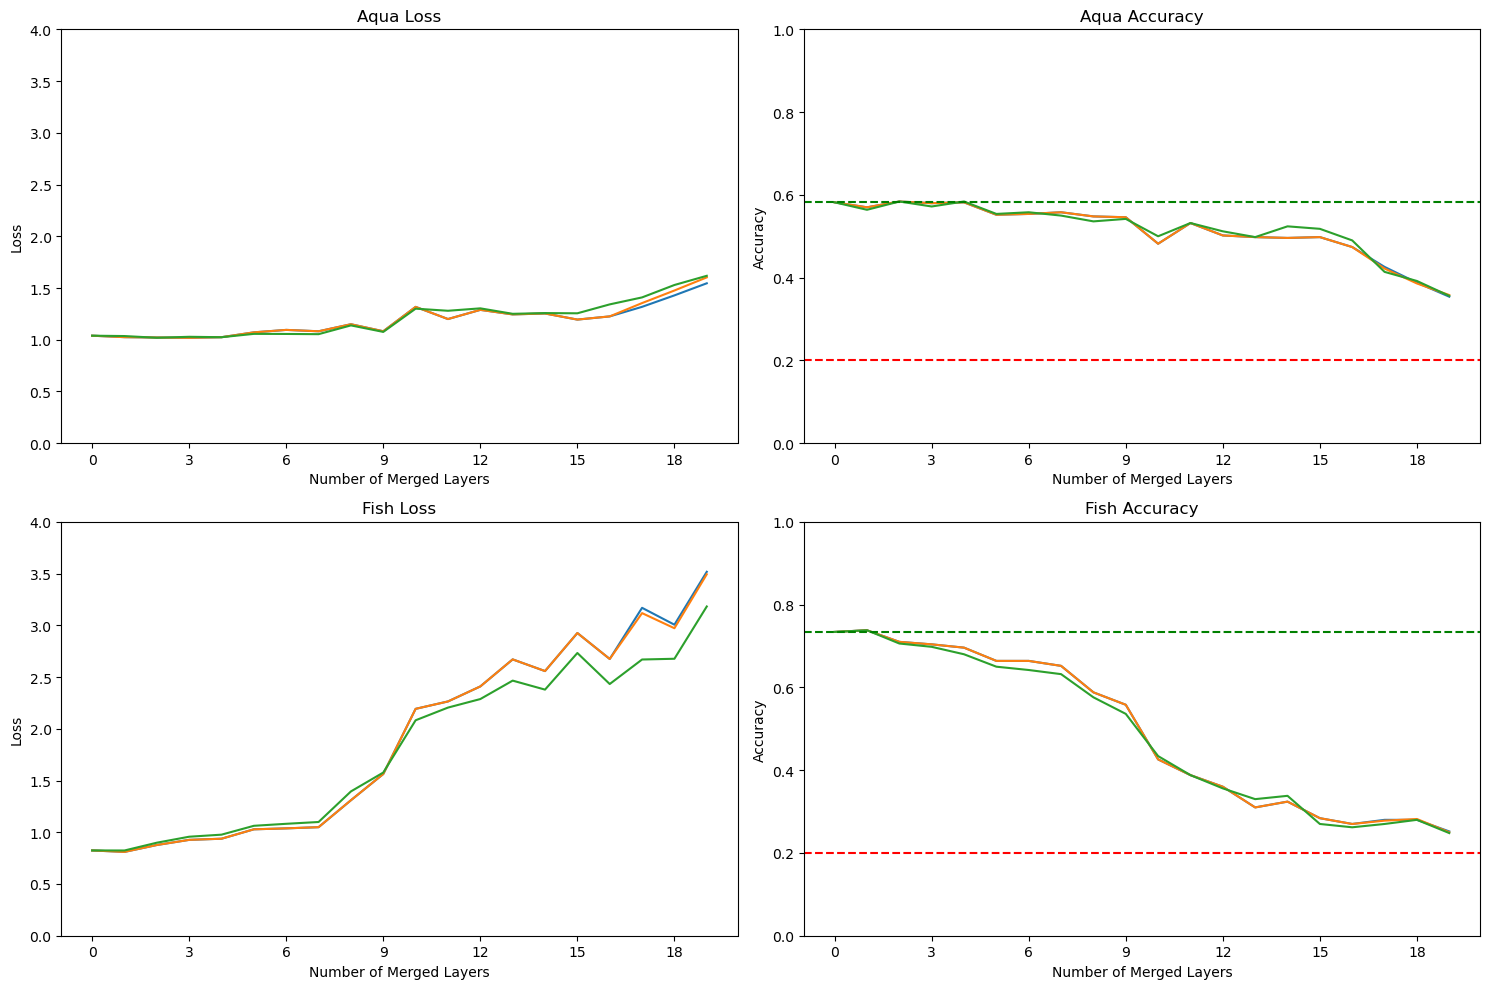

In [199]:
# Reinitialize the merged model with model fish and aqua
merged_model = MergedModel(aquatic, fish,coarse_model)
# Merge all the conv2d layers one by one and evaluate the two partial merge models on dataset aqua and fish respectively
# add loss and accuracy list for aqua and fish
aqua_loss_list = []
aqua_acc_list = []
fish_loss_list = []
fish_acc_list = []
aqua_loss_list2 = []
aqua_acc_list2 = []
fish_loss_list2 = []
fish_acc_list2 = []
aqua_loss_list3 = []
aqua_acc_list3 = []
fish_loss_list3 = []
fish_acc_list3 = []
for i in range(20):
    merged_model.merge_layers(i)
    aqua_loss, aqua_acc = test(merged_model.partial_merge_model1, aqua_testloader)
    fish_loss, fish_acc = test(merged_model.partial_merge_model2, fish_testloader)
    # apply the merge_layers_average function to merge the conv2d layers by averaging
    merged_model.merge_layers_average(i)
    aqua_loss2, aqua_acc2 = test(merged_model.partial_merge_model1, aqua_testloader)
    fish_loss2, fish_acc2 = test(merged_model.partial_merge_model2, fish_testloader)
    # apply the merge_layers_with_reference function to merge the conv2d layers by using the original model as reference
    merged_model.merge_layers_with_reference(i)
    aqua_loss3, aqua_acc3 = test(merged_model.partial_merge_model1, aqua_testloader)
    fish_loss3, fish_acc3 = test(merged_model.partial_merge_model2, fish_testloader)
    # append loss and accuracy to the list
    aqua_loss_list.append(aqua_loss)
    aqua_acc_list.append(aqua_acc)
    fish_loss_list.append(fish_loss)
    fish_acc_list.append(fish_acc)
    aqua_loss_list2.append(aqua_loss2)
    aqua_acc_list2.append(aqua_acc2)
    fish_loss_list2.append(fish_loss2)
    fish_acc_list2.append(fish_acc2)
    aqua_loss_list3.append(aqua_loss3)
    aqua_acc_list3.append(aqua_acc3)
    fish_loss_list3.append(fish_loss3)
    fish_acc_list3.append(fish_acc3)
# plot the loss and accuracy of the two partial merge models on dataset aqua and fish respectively
# make it a 2x2 plot with x-axis as the number of merged layers and y-axis as the loss or accuracy



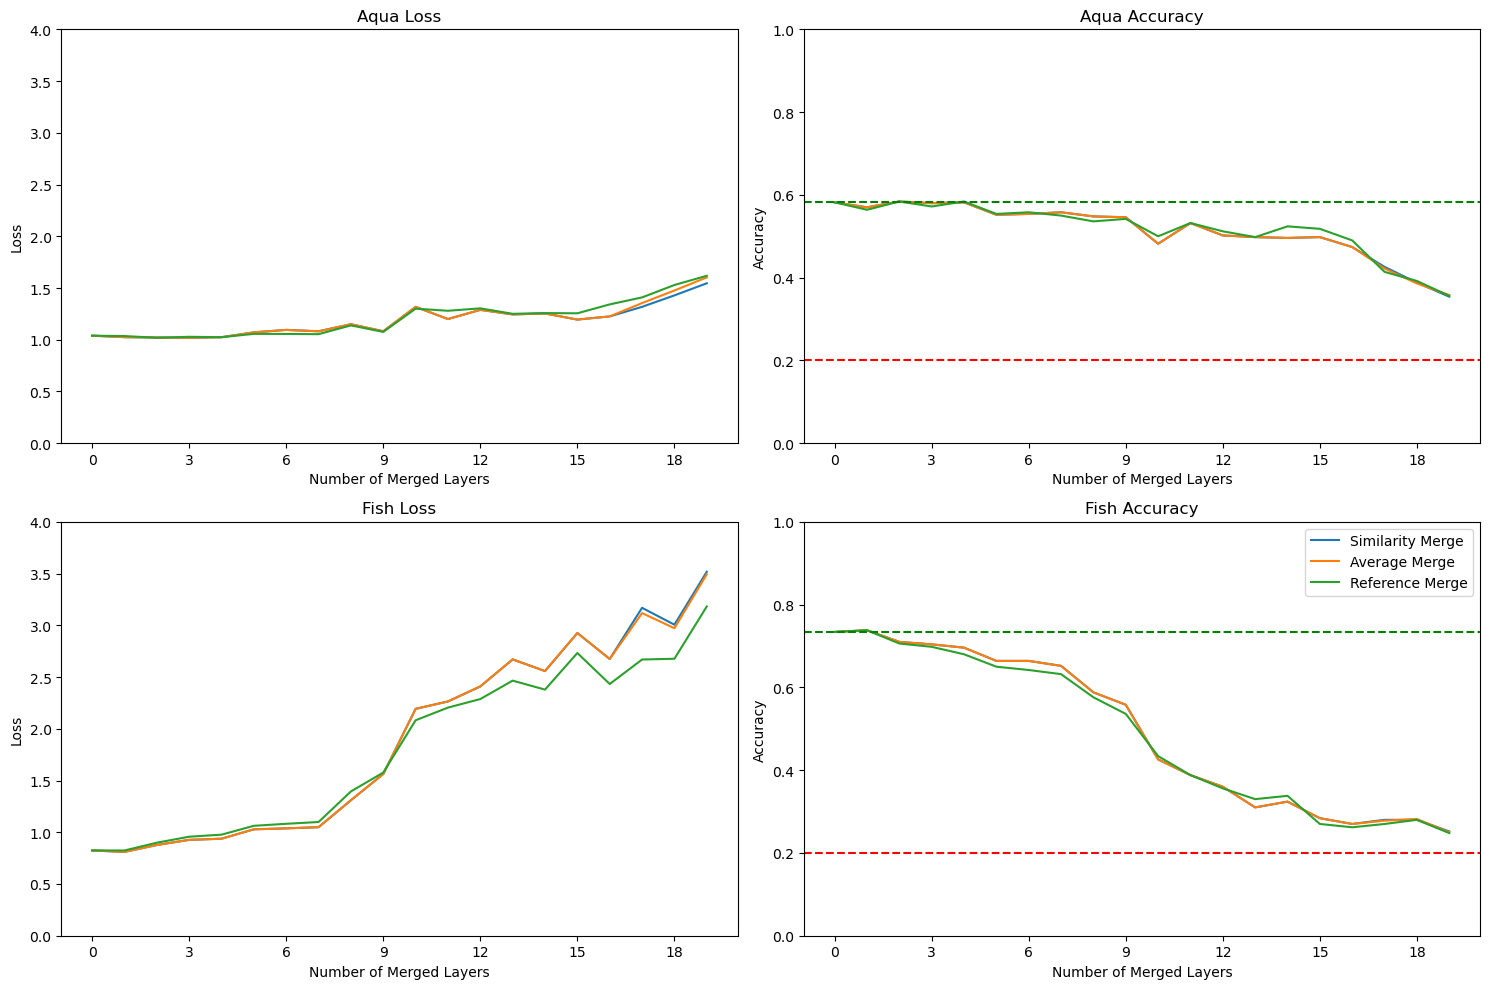

In [201]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(range(20), aqua_loss_list, label='Similarity Merge')
axs[0, 0].plot(range(20), aqua_loss_list2, label='Average Merge')
axs[0, 0].plot(range(20), aqua_loss_list3, label='Reference Merge')
axs[0, 0].set_title('Aqua Loss')
axs[0, 0].set_xlabel('Number of Merged Layers')
axs[0, 0].set_ylabel('Loss')
axs[0, 1].plot(range(20), aqua_acc_list, label='Similarity Merge')
axs[0, 1].plot(range(20), aqua_acc_list2, label='Average Merge')
axs[0, 1].plot(range(20), aqua_acc_list3, label='Reference Merge')
axs[0, 1].set_title('Aqua Accuracy')
axs[0, 1].set_xlabel('Number of Merged Layers')
axs[0, 1].set_ylabel('Accuracy')
axs[1, 0].plot(range(20), fish_loss_list, label='Similarity Merge')
axs[1, 0].plot(range(20), fish_loss_list2, label='Average Merge')
axs[1, 0].plot(range(20), fish_loss_list3, label='Reference Merge')
axs[1, 0].set_title('Fish Loss')
axs[1, 0].set_xlabel('Number of Merged Layers')
axs[1, 0].set_ylabel('Loss')
axs[1, 1].plot(range(20), fish_acc_list, label='Similarity Merge')
axs[1, 1].plot(range(20), fish_acc_list2, label='Average Merge')
axs[1, 1].plot(range(20), fish_acc_list3, label='Reference Merge')
axs[1, 1].set_title('Fish Accuracy')
axs[1, 1].set_xlabel('Number of Merged Layers')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
# set x ticks to be integers
for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# draw horizontal y = 0.2 line on the accuracy plots
for ax in axs[0, 1], axs[1, 1]:
    ax.axhline(y=0.2, color='r', linestyle='--')
# set y limit for accuracy plots to be [0, 1]
for ax in axs[0, 1], axs[1, 1]:
    ax.set_ylim([0, 1])
# set y limt for loss plots to be [0, 4]
for ax in axs[0, 0], axs[1, 0]:
    ax.set_ylim([0, 4])
# draw horizontal line on the accurayc plots showing the accuracy of the original models
axs[0,1].axhline(y=0.584, color='g', linestyle='--')
axs[1,1].axhline(y=0.734, color='g', linestyle='--')
plt.tight_layout()
plt.show()

In [107]:
# NOT USED FOR PROJECT REPORT
# Function that selects the samples from the train and test dataset baed on the sparse2coarse function
def make_dataloader(trainset, testset, index, augmentation_transform, transform, batch_size = 32):
    # Train
    index = index.tolist()
    train_idx = [i for i in trainsplit_coarse_idx.indices if sparse2coarse(trainset.targets[i]) in index]
    valid_idx = [i for i in validsplit_coarse_idx.indices if sparse2coarse(trainset.targets[i]) in index]
    dataset = TransformedSubset(trainset, train_idx, augmentation_transform)
    valid_dataset =TransformedSubset(trainset, valid_idx, transform)
    trainloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
    validloader = DataLoader(valid_dataset, batch_size = batch_size)
    # Test
    test_idx = [i for i in range(len(testset)) if sparse2coarse(testset.targets[i]) in  index]
    testdataset = TransformedSubset(testset, test_idx, transform)
    testloader = DataLoader(testdataset, batch_size = 32)
    return trainloader, validloader, testloader
# function to load the coarse model into the base model from torch hub
def load_coarse_model():
    base_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=False)
    base_model.fc = torch.nn.Linear(base_model.fc.in_features, 20)
    checkpoint = torch.load('resnet20_coarse_real.pth', map_location='cuda')
    base_model.load_state_dict(checkpoint['model_state_dict'])
    # modify the model to have 100 output classes
    base_model.fc = torch.nn.Linear(base_model.fc.in_features, 100)
    return base_model
# test merging accuracy
def test_merging_method(num_classes = 1):
    # choose two random coarse labels
    index = np.random.choice(20, 2 * num_classes, replace=False)
    print(index)
    # make dataloader for the two coarse labels
    trainloader, validloader, testloader = make_dataloader(trainset, testset, index[0:num_classes], augmentation_transform, transform)
    trainloader2, validloader2, testloader2 = make_dataloader(trainset, testset, index[num_classes:], augmentation_transform, transform)
    # generate base model
    base_model = load_coarse_model()
    # deepcoy the base model into two models
    model1 = deepcopy(base_model)
    model2 = deepcopy(base_model)
    # fine tune the model on the two coarse labels
    a,b,c,d = train(model1, trainloader, validloader, 20, '.', 'model1')
    a,b,c,d = train(model2, trainloader2, validloader2, 20, '.', 'model2')
    # initialize the merged model
    merged_model = MergedModel(model1, model2, coarse_model)
    # initialize accuracy list for two datasets
    acc_list1 = []
    acc_list2 = []
    acc_avg_list1 = []
    acc_avg_list2 = []
    # merge the two models one by one and test the merged model on the two datasets
    for i in range(20):
        merged_model.merge_layers(i)
        cost1, acc1 = test(merged_model.partial_merge_model1, testloader)
        cost2, acc2 = test(merged_model.partial_merge_model2, testloader2)
        acc_list1.append(acc1)
        acc_list2.append(acc2)
        merged_model.merge_layers_average(i)
        cost1, acc1 = test(merged_model.partial_merge_model1, testloader)
        cost2, acc2 = test(merged_model.partial_merge_model2, testloader2)
        acc_avg_list1.append(acc1)
        acc_avg_list2.append(acc2)
    return acc_list1, acc_list2, acc_avg_list1, acc_avg_list2

In [112]:
# NOT USED
acc_list_glob1, acc_list_glob2, acc_list_avg_glob1, acc_list_avg_glob2 = test_merging_method(num_classes = 3)

Using cache found in C:\Users\TravisYou/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Training on device: cuda
Epoch: 0, TrainingLoss: 1.6667039654266214, TrainingAccuracy: 0.4563092589378357, ValidationLoss: 1.5024634053309758, ValidationAccuracy: 0.4799465239048004
Best Loss: saving model...
Epoch: 1, TrainingLoss: 1.2687316649897968, TrainingAccuracy: 0.5703495740890503, ValidationLoss: 1.3087284838159878, ValidationAccuracy: 0.5441176295280457
Best Loss: saving model...
Epoch: 2, TrainingLoss: 1.1673636281094846, TrainingAccuracy: 0.6097452640533447, ValidationLoss: 1.1449255620439847, ValidationAccuracy: 0.6270053386688232
Best Loss: saving model...
Epoch: 3, TrainingLoss: 1.082304073736001, TrainingAccuracy: 0.6402547359466553, ValidationLoss: 1.334651341040929, ValidationAccuracy: 0.5588235259056091
Epoch: 4, TrainingLoss: 1.0563086454902215, TrainingAccuracy: 0.6538803577423096, ValidationLoss: 1.0351096168160439, ValidationAccuracy: 0.6711230278015137
Best Loss: saving model...
Epoch: 5, TrainingLoss: 0.9991282563638914, TrainingAccuracy: 0.6664692163467407, Va

In [164]:
# split 2013 train to train and valid
trainset_fer2013, validset_fer2013, testset_fer2013 = random_split(fer2013train, [0.8,0.1,0.1])
# Transform to apply to the training set of FER2013
grayscale_aug_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Transform to apply to the validation and testing set of FER2013
grayscale_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Set up the Dataloaders for training, validation and testing
trainset_fer2013.dataset.transform = grayscale_aug_transform
validset_fer2013.dataset.transform = grayscale_transform
testset_fer2013.dataset.transform = grayscale_transform
trainloader_fer2013 = DataLoader(trainset_fer2013, batch_size = 256, shuffle = True)
validloader_fer2013 = DataLoader(validset_fer2013, batch_size = 256)
testloader_fer2013 = DataLoader(testset_fer2013, batch_size = 256)
# load resnet18 from pytorch hub
modelfer2013 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
# modify the model to have 8 output classes
modelfer2013.fc = torch.nn.Linear(modelfer2013.fc.in_features, 8)
# train the model using the train function
trloss_arr, tracc_arr, vldloss_arr, vldacc_arr = train(modelfer2013, trainloader_fer2013, validloader_fer2013, 20, '.', 'resnet18_fer2013')

Using cache found in C:\Users\TravisYou/.cache\torch\hub\pytorch_vision_v0.9.0
c:\Users\TravisYou\anaconda3\envs\jovolab\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TravisYou\anaconda3\envs\jovolab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training on device: cuda


C:\Users\TravisYou\AppData\Local\Temp\ipykernel_10292\3454451692.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels, dtype = torch.long).to(device)


Epoch: 0, TrainingLoss: 3.714769072002835, TrainingAccuracy: 0.2317136824131012, ValidationLoss: 1.8510398070017497, ValidationAccuracy: 0.2511320114135742
Best Loss: saving model...
Epoch: 1, TrainingLoss: 1.80612809393141, TrainingAccuracy: 0.2534830868244171, ValidationLoss: 1.8119343121846516, ValidationAccuracy: 0.24660396575927734
Best Loss: saving model...
Epoch: 2, TrainingLoss: 1.7883079436090257, TrainingAccuracy: 0.255442351102829, ValidationLoss: 1.7969886561234791, ValidationAccuracy: 0.2514803111553192
Best Loss: saving model...
Epoch: 3, TrainingLoss: 1.776437360710568, TrainingAccuracy: 0.2601880729198456, ValidationLoss: 1.802152196566264, ValidationAccuracy: 0.2556600570678711
Epoch: 4, TrainingLoss: 1.7662620902061463, TrainingAccuracy: 0.2682863175868988, ValidationLoss: 1.775722086429596, ValidationAccuracy: 0.26541274785995483
Best Loss: saving model...
Epoch: 5, TrainingLoss: 1.7389575521151224, TrainingAccuracy: 0.2916666567325592, ValidationLoss: 1.740633070468

In [166]:
# load resnet 18 from pytorch
modelcoarse = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
# modify the model to have 20 output classes
modelcoarse.fc = torch.nn.Linear(modelcoarse.fc.in_features, 20)
# train the model using the train function
trloss_arr, tracc_arr, vldloss_arr, vldacc_arr = train(modelcoarse, coarsetrain_loader, coarsevalid_loader, 20, '.', 'resnet18_coarse')

Using cache found in C:\Users\TravisYou/.cache\torch\hub\pytorch_vision_v0.9.0
c:\Users\TravisYou\anaconda3\envs\jovolab\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TravisYou\anaconda3\envs\jovolab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training on device: cuda


C:\Users\TravisYou\AppData\Local\Temp\ipykernel_10292\3454451692.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels, dtype = torch.long).to(device)


Epoch: 0, TrainingLoss: 3.1918354589830744, TrainingAccuracy: 0.11382222175598145, ValidationLoss: 3.1240386843681334, ValidationAccuracy: 0.1664000004529953
Best Loss: saving model...
Epoch: 1, TrainingLoss: 2.655377210541205, TrainingAccuracy: 0.19111111760139465, ValidationLoss: 2.731066632270813, ValidationAccuracy: 0.22059999406337738
Best Loss: saving model...
Epoch: 2, TrainingLoss: 2.415126617659222, TrainingAccuracy: 0.25546666979789734, ValidationLoss: 2.4081628799438475, ValidationAccuracy: 0.2784000039100647
Best Loss: saving model...
Epoch: 3, TrainingLoss: 2.214552739804441, TrainingAccuracy: 0.3076888918876648, ValidationLoss: 2.132360851764679, ValidationAccuracy: 0.34199997782707214
Best Loss: saving model...
Epoch: 4, TrainingLoss: 2.07319055091251, TrainingAccuracy: 0.3532666563987732, ValidationLoss: 2.7372927606105804, ValidationAccuracy: 0.38519999384880066
Epoch: 5, TrainingLoss: 1.9609311778437009, TrainingAccuracy: 0.3858666718006134, ValidationLoss: 1.89855090

In [203]:
# merge the model and model2, with reference model as the pretrained pytorhc model
merged_model = MergedModel(modelfer2013, modelcoarse, torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True))
# merge the layers sequentially, and evaluate the two partial merge models
emo_loss_list1 = []
cf100_loss_list1 = []
emo_acc_list1 = []
cf100_acc_list1 = []
emo_loss_list2 = []
cf100_loss_list2 = []
emo_acc_list2 = []
cf100_acc_list2 = []
emo_loss_list3 = []
cf100_loss_list3 = []
emo_acc_list3 = []
cf100_acc_list3 = []
for i in range(18):
    merged_model.merge_layers(i)
    emo_loss1, emo_acc1 = test(merged_model.partial_merge_model1, testloader_fer2013)
    cf100_loss1, cf100_acc1 = test(merged_model.partial_merge_model2, coarsetest_loader)
    merged_model.merge_layers_average(i)
    emo_loss2, emo_acc2 = test(merged_model.partial_merge_model1, testloader_fer2013)
    cf100_loss2, cf100_acc2 = test(merged_model.partial_merge_model2, coarsetest_loader)
    merged_model.merge_layers_with_reference(i)
    emo_loss3, emo_acc3 = test(merged_model.partial_merge_model1, testloader_fer2013)
    cf100_loss3, cf100_acc3 = test(merged_model.partial_merge_model2, coarsetest_loader)
    emo_loss_list1.append(emo_loss1)
    cf100_loss_list1.append(cf100_loss1)
    emo_acc_list1.append(emo_acc1)
    cf100_acc_list1.append(cf100_acc1)
    emo_loss_list2.append(emo_loss2)
    cf100_loss_list2.append(cf100_loss2)
    emo_acc_list2.append(emo_acc2)
    cf100_acc_list2.append(cf100_acc2)
    emo_loss_list3.append(emo_loss3)
    cf100_loss_list3.append(cf100_loss3)
    emo_acc_list3.append(emo_acc3)
    cf100_acc_list3.append(cf100_acc3)
    



Using cache found in C:\Users\TravisYou/.cache\torch\hub\pytorch_vision_v0.9.0
c:\Users\TravisYou\anaconda3\envs\jovolab\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TravisYou\anaconda3\envs\jovolab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss: 1.5245937605698903, Test Accuracy: 0.41358885169029236
Test Loss: 1.460471361875534, Test Accuracy: 0.538599967956543
Test Loss: 1.5245937605698903, Test Accuracy: 0.41358885169029236
Test Loss: 1.4709014236927032, Test Accuracy: 0.538599967956543
Test Loss: 1.5245937605698903, Test Accuracy: 0.41358885169029236
Test Loss: 1.4548410803079606, Test Accuracy: 0.538599967956543
Test Loss: 1.5309755007425945, Test Accuracy: 0.40243902802467346
Test Loss: 3.810866582393646, Test Accuracy: 0.08190000057220459
Test Loss: 1.623997191588084, Test Accuracy: 0.36376306414604187
Test Loss: 3.092161351442337, Test Accuracy: 0.18519999086856842
Test Loss: 1.6831928292910259, Test Accuracy: 0.33519163727760315
Test Loss: 3.6394609451293944, Test Accuracy: 0.13570000231266022
Test Loss: 1.539867987235387, Test Accuracy: 0.399303138256073
Test Loss: 3.7550291299819945, Test Accuracy: 0.07939999550580978
Test Loss: 1.7959622740745544, Test Accuracy: 0.30662021040916443
Test Loss: 3.0578122496

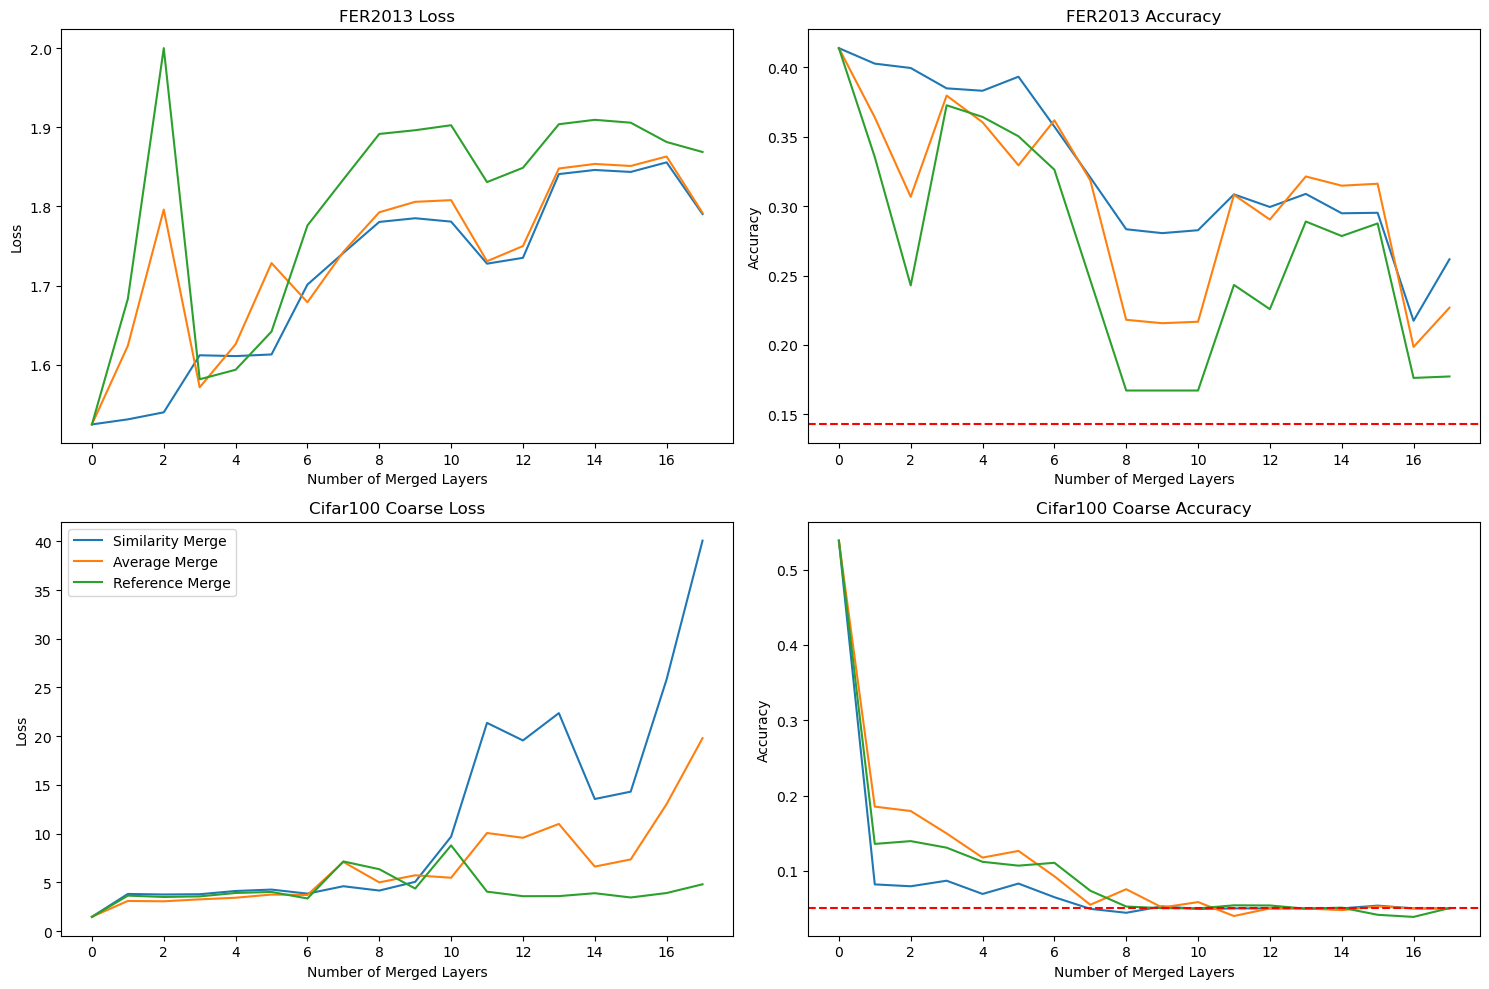

In [211]:
# plot the loss and accuracy of the two partial merge models on dataset fer2013 and cifar100 respectively

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# plot all three list of emo loss
axs[0, 0].plot(range(18), emo_loss_list1)
axs[0, 0].plot(range(18), emo_loss_list2)
axs[0, 0].plot(range(18), emo_loss_list3)

axs[0, 0].set_title('FER2013 Loss')
axs[0, 0].set_xlabel('Number of Merged Layers')
axs[0, 0].set_ylabel('Loss')
axs[0, 1].plot(range(18), emo_acc_list1)
axs[0, 1].plot(range(18), emo_acc_list2)
axs[0, 1].plot(range(18), emo_acc_list3)
axs[0, 1].set_title('FER2013 Accuracy')
axs[0, 1].set_xlabel('Number of Merged Layers')
axs[0, 1].set_ylabel('Accuracy')
axs[1, 0].plot(range(18), cf100_loss_list1, label='Similarity Merge')
axs[1, 0].plot(range(18), cf100_loss_list2, label='Average Merge')
axs[1, 0].plot(range(18), cf100_loss_list3, label='Reference Merge')
axs[1, 0].set_title('Cifar100 Coarse Loss')
axs[1, 0].set_xlabel('Number of Merged Layers')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()
axs[1, 1].plot(range(18), cf100_acc_list1, label='Similarity Merge')
axs[1, 1].plot(range(18), cf100_acc_list2, label='Average Merge')
axs[1, 1].plot(range(18), cf100_acc_list3, label='Reference Merge')
axs[1, 1].set_title('Cifar100 Coarse Accuracy')
axs[1, 1].set_xlabel('Number of Merged Layers')
axs[1, 1].set_ylabel('Accuracy')
# set x ticks to be integers
for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# draw horizontal y = 0.05 line on the bottom accuracy plots
axs[0,1].axhline(y=1/7, color='r', linestyle='--')
axs[1,1].axhline(y=0.05, color='r', linestyle='--')
plt.tight_layout()
plt.show()